# EDA and Cleaning

Imports

In [1]:
import pandas as pd
import numpy as np
import time, json

import sshtunnel
import mysql.connector
from mysql.connector import errorcode

Helper Functions

In [2]:
def name_extractor(x):
    try:
        return eval(x)['name']
    except:
        return None

    
print(name_extractor('{"name": "test"}'))    
    

test


In [3]:
def get_lat(x):
    try:
        return str(x).split(',')[0]
    except:
        return None
    
def get_long(x):
    try:
        return str(x).split(',')[1]
    except:
        return None
        
print(get_lat('-1.5398388646,35.012608336'), get_long('-1.5398388646,35.012608336'))

-1.5398388646 35.012608336


In [4]:
def name_geo_time(pandas_df):
    return (
        pandas_df['taxon'].apply(name_extractor), 
        pandas_df['location'].apply(get_lat), 
        pandas_df['location'].apply(get_long), 
        pandas_df['created_at'].str.split('T', expand=True)[0]
    )

# Elephant MoveBank

In [5]:
research = pd.read_csv('../data/research.csv')
research.shape

(99988, 10)

In [6]:
research.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name
0,7980499272,True,2008-10-30 00:15:00.000,16.202088,-19.063725,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...
1,7980499273,True,2008-10-30 02:46:00.000,16.209496,-19.069908,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...
2,7980499274,True,2008-10-30 03:31:00.000,16.214184,-19.068719,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...
3,7980499275,True,2008-10-30 03:45:00.000,16.214170,-19.068683,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...
4,7980499276,True,2008-10-30 05:31:00.000,16.229372,-19.058258,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...


In [28]:
print(research['timestamp'].max(), 'TO', research['timestamp'].min())

2014-03-27 17:40:00.000 TO 2008-10-30 00:15:00.000


In [24]:
research['tag-local-identifier'].nunique()

15

15 Elephants tracked.

Time period spans from Oct 2008 to March 2014, data gathered every ~15mins to 3+hrs

Rough plot of movement:

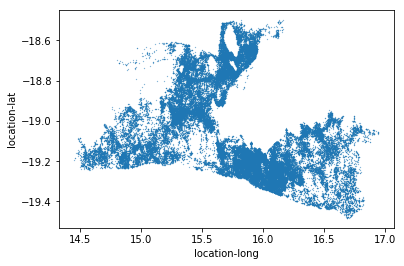

In [29]:
research.plot(kind='scatter', x='location-long', y='location-lat', s=.05)

In [9]:
research['individual-taxon-canonical-name'].value_counts()

Loxodonta africana    99988
Name: individual-taxon-canonical-name, dtype: int64

In [10]:
research['date'] = research['timestamp'].str.split(' ', expand=True)[0]

research_to_sql = research[['location-lat', 'location-long', 'date', 'individual-taxon-canonical-name', 'tag-local-identifier']]
research_to_sql.head()

,location-lat,location-long,date,individual-taxon-canonical-name,tag-local-identifier
0,-19.063725,16.202088,2008-10-30,Loxodonta africana,AG005
1,-19.069908,16.209496,2008-10-30,Loxodonta africana,AG005
2,-19.068719,16.214184,2008-10-30,Loxodonta africana,AG005
3,-19.068683,16.214170,2008-10-30,Loxodonta africana,AG005
4,-19.058258,16.229372,2008-10-30,Loxodonta africana,AG005


In [11]:
research_to_sql.to_csv('../data/research_to_sql.csv', index=False)

## iNaturalist Sightings

In [12]:
sightings = pd.read_csv('../data/raw_elp.csv')
sightings = sightings[sightings['captive'] == False]

sightings.head()

,annotations,cached_votes_total,captive,comments,comments_count,community_taxon_id,context_geoprivacy,context_taxon_geoprivacy,context_user_geoprivacy,created_at,...,tags,taxon,taxon_geoprivacy,time_observed_at,time_zone_offset,updated_at,uri,user,uuid,votes
0,[],0,False,[],0,43694.0,NaN,NaN,NaN,2019-11-09T22:32:16+00:00,...,[],"{'is_active': True, 'ancestry': '48460/1/2/355...",obscured,NaN,+00:00,2019-11-09T23:22:14+00:00,https://www.inaturalist.org/observations/35505414,"{'created_at': '2019-03-28T17:16:18+00:00', 'i...",05607e16-7040-4afa-9743-1387a19a6f9f,[]
1,[],0,False,[],0,43694.0,NaN,NaN,NaN,2019-11-09T22:32:16+00:00,...,[],"{'is_active': True, 'ancestry': '48460/1/2/355...",obscured,NaN,+00:00,2019-11-09T23:22:19+00:00,https://www.inaturalist.org/observations/35505412,"{'created_at': '2019-03-28T17:16:18+00:00', 'i...",87e81e4d-fe9e-466c-b448-a95057a31ff9,[]
2,[],0,False,[],0,43694.0,NaN,NaN,NaN,2019-11-09T16:39:02+01:00,...,[],"{'is_active': True, 'ancestry': '48460/1/2/355...",obscured,2019-08-11T12:32:00+02:00,+01:00,2019-11-10T00:01:53+01:00,https://www.inaturalist.org/observations/35489877,"{'created_at': '2019-11-09T14:55:11+00:00', 'i...",badb19e5-148e-46c6-80bc-b758fda9176d,[]
3,[],0,False,[],0,43694.0,NaN,NaN,NaN,2019-11-09T16:50:10+02:00,...,[],"{'is_active': True, 'ancestry': '48460/1/2/355...",obscured,2007-03-30T11:58:00+02:00,+02:00,2019-11-10T01:05:19+02:00,https://www.inaturalist.org/observations/35488391,"{'created_at': '2017-10-06T19:53:45+00:00', 'i...",879143fd-5774-4e34-b2c5-c08728365325,[]
4,[],0,False,[],0,43694.0,NaN,NaN,NaN,2019-11-08T14:49:13-08:00,...,[],"{'is_active': True, 'ancestry': '48460/1/2/355...",obscured,2019-10-05T10:06:00-07:00,-08:00,2019-11-09T02:23:24-08:00,https://www.inaturalist.org/observations/35466034,"{'created_at': '2015-03-16T22:46:00+00:00', 'i...",125ed0d3-2af6-4291-a2a1-8627e57bbcb8,[]


In [13]:
list(sightings.columns)

['annotations',
 'cached_votes_total',
 'captive',
 'comments',
 'comments_count',
 'community_taxon_id',
 'context_geoprivacy',
 'context_taxon_geoprivacy',
 'context_user_geoprivacy',
 'created_at',
 'created_at_details',
 'created_time_zone',
 'description',
 'faves',
 'faves_count',
 'flags',
 'geojson',
 'geoprivacy',
 'id',
 'id_please',
 'ident_taxon_ids',
 'identifications',
 'identifications_count',
 'identifications_most_agree',
 'identifications_most_disagree',
 'identifications_some_agree',
 'license_code',
 'location',
 'map_scale',
 'mappable',
 'non_owner_ids',
 'num_identification_agreements',
 'num_identification_disagreements',
 'oauth_application_id',
 'obscured',
 'observation_photos',
 'observation_sounds',
 'observed_on',
 'observed_on_details',
 'observed_on_string',
 'observed_time_zone',
 'ofvs',
 'out_of_range',
 'outlinks',
 'owners_identification_from_vision',
 'photos',
 'place_guess',
 'place_ids',
 'positional_accuracy',
 'preferences',
 'project_ids',
 '

In [14]:
sightings['species'], sightings['lat'], sightings['long'], sightings['date'] = name_geo_time(sightings)

sightings_to_sql = sightings[['lat', 'long', 'date', 'species', 'uri',]]
sightings_to_sql.head()

,lat,long,date,species,uri
0,-1.5398388646,35.012608336,2019-11-09,Loxodonta africana,https://www.inaturalist.org/observations/35505414
1,0.3507374091,37.5253124093,2019-11-09,Loxodonta africana,https://www.inaturalist.org/observations/35505412
2,-33.524746457,25.7267441351,2019-11-09,Loxodonta africana,https://www.inaturalist.org/observations/35489877
3,-28.3921907196,31.8279838425,2019-11-09,Loxodonta africana,https://www.inaturalist.org/observations/35488391
4,-33.4887225126,25.9328101723,2019-11-08,Loxodonta africana,https://www.inaturalist.org/observations/35466034


In [15]:
sightings_to_sql.to_csv('../data/sightings_to_sql.csv', index=False)

## Additional Sightings

In [22]:
alt_counts = pd.read_csv('../data/species_counts.csv')
len(alt_counts['taxon'].apply(name_extractor).unique())

164